## Notebook imports

In [221]:
from os import walk
from os.path import join

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

%matplotlib inline

## Constants

In [260]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1/'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2/'

HAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/'
HAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2/'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SCULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMB_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

FONT_FILE_BOLD = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'
FONT_FILE_LIGHT = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Light.ttf'


## Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator function

In [6]:
def generate_squares(N):
        for my_number in range(N):
            yield my_number ** 2

In [7]:
for i in generate_squares(6):
    print(i, end=' -> ')

0 -> 1 -> 4 -> 9 -> 16 -> 25 -> 

## Email body extraction

In [8]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [9]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))

In [11]:
ham_emails = df_from_directory(HAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(HAM_2_PATH, HAM_CAT))

In [12]:
data = pd.concat([spam_emails, ham_emails])

In [13]:
data.tail()

MESSAGE  \
01396.61983fbe6ec43f55fd44e30fce24ffa6  http://news.bbc.co.uk/1/hi/england/2515127.stm...   
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  > >-- be careful when using this one.) Also, t...   
01398.169b51731fe569f42169ae8f948ec676  >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...   
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  So then, "Mark Hammond" <mhammond@skippinet.co...   
01400.f897f0931e461e7b2e964d28e927c35e  Hi there,\n\n\n\nNow this is probably of no us...   

                                        CATEGORY  
01396.61983fbe6ec43f55fd44e30fce24ffa6         0  
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7         0  
01398.169b51731fe569f42169ae8f948ec676         0  
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896         0  
01400.f897f0931e461e7b2e964d28e927c35e         0

## Data Cleaning: Checking for Missing Values

In [14]:
data['MESSAGE'].isnull().values.any()

False

In [15]:
(data.MESSAGE.str.len() == 0).any()

True

In [16]:
(data.MESSAGE.str.len() == 0).sum()

3

In [17]:
(data.MESSAGE.str.len() == None).sum()

0

In [18]:
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [19]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [20]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [21]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

## Remove System File Entries from Dataframe

In [22]:
data.drop(['cmds'], inplace=True)

In [23]:
data.shape

(5796, 2)

# Add Document IDs to track Emails in Dataset

In [24]:
document_ids = range(0, 5796)

In [25]:
data['DOC_ID'] = document_ids

In [26]:
data['FILE_NAME'] = data.index
data


MESSAGE  \
00001.7848dde101aa985090474a91ec93fcf0  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
00002.d94f1b97e48ed3b553b3508d116e6a09  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00003.2ee33bc6eacdb11f38d052c44819ba6c  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00004.eac8de8d759b7e74154f142194282724  ##############################################...   
00005.57696a39d7d84318ce497886896bf90d  I thought you might like these:\n\n1) Slim Dow...   
...                                                                                   ...   
01396.61983fbe6ec43f55fd44e30fce24ffa6  http://news.bbc.co.uk/1/hi/england/2515127.stm...   
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  > >-- be careful when using this one.) Also, t...   
01398.169b51731fe569f42169ae8f948ec676  >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...   
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  So then, "Mark Hammond" <mhammond@skippinet.co...   
01400.f897f0931e461e7b2e964d28e927c35e  Hi there,\n\n\n\nNow this is probably of no us...   

                                        CATEGORY  DOC_ID  \
00001.7848dde101aa985090474a91ec93fcf0         1       0   
00002.d94f1b97e48ed3b553b3508d116e6a09         1       1   
00003.2ee33bc6eacdb11f38d052c44819ba6c         1       2   
00004.eac8de8d759b7e74154f142194282724         1       3   
00005.57696a39d7d84318ce497886896bf90d         1       4   
...                                          ...     ...   
01396.61983fbe6ec43f55fd44e30fce24ffa6         0    5791   
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7         0    5792   
01398.169b51731fe569f42169ae8f948ec676         0    5793   
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896         0    5794   
01400.f897f0931e461e7b2e964d28e927c35e         0    5795   

                                                                     FILE_NAME  
00001.7848dde101aa985090474a91ec93fcf0  00001.7848dde101aa985090474a91ec93fcf0  
00002.d94f1b97e48ed3b553b3508d116e6a09  00002.d94f1b97e48ed3b553b3508d116e6a09  
00003.2ee33bc6eacdb11f38d052c44819ba6c  00003.2ee33bc6eacdb11f38d052c44819ba6c  
00004.eac8de8d759b7e74154f142194282724  00004.eac8de8d759b7e74154f142194282724  
00005.57696a39d7d84318ce497886896bf90d  00005.57696a39d7d84318ce497886896bf90d  
...                                                                        ...  
01396.61983fbe6ec43f55fd44e30fce24ffa6  01396.61983fbe6ec43f55fd44e30fce24ffa6  
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  
01398.169b51731fe569f42169ae8f948ec676  01398.169b51731fe569f42169ae8f948ec676  
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  
01400.f897f0931e461e7b2e964d28e927c35e  01400.f897f0931e461e7b2e964d28e927c35e  

[5796 rows x 4 columns]

In [27]:
data.set_index('DOC_ID', inplace=True)

In [28]:
data

MESSAGE  CATEGORY  \
DOC_ID                                                                
0       <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...         1   
1       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
2       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
3       ##############################################...         1   
4       I thought you might like these:\n\n1) Slim Dow...         1   
...                                                   ...       ...   
5791    http://news.bbc.co.uk/1/hi/england/2515127.stm...         0   
5792    > >-- be careful when using this one.) Also, t...         0   
5793    >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...         0   
5794    So then, "Mark Hammond" <mhammond@skippinet.co...         0   
5795    Hi there,\n\n\n\nNow this is probably of no us...         0   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09  
2       00003.2ee33bc6eacdb11f38d052c44819ba6c  
3       00004.eac8de8d759b7e74154f142194282724  
4       00005.57696a39d7d84318ce497886896bf90d  
...                                        ...  
5791    01396.61983fbe6ec43f55fd44e30fce24ffa6  
5792    01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  
5793    01398.169b51731fe569f42169ae8f948ec676  
5794    01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  
5795    01400.f897f0931e461e7b2e964d28e927c35e  

[5796 rows x 3 columns]

# Save to file using Pandas

In [29]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Vis (pie chart)

In [30]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [31]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

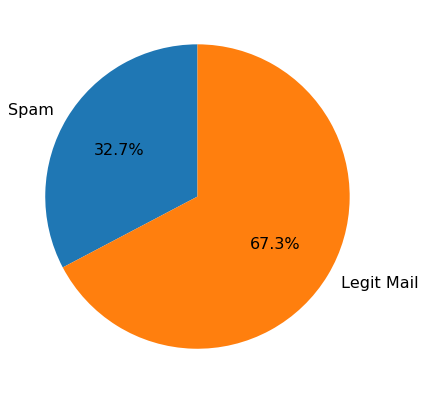

In [32]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels = category_names, textprops={'fontsize': 16}, startangle=90,
       autopct='%1.1f%%')
plt.show()

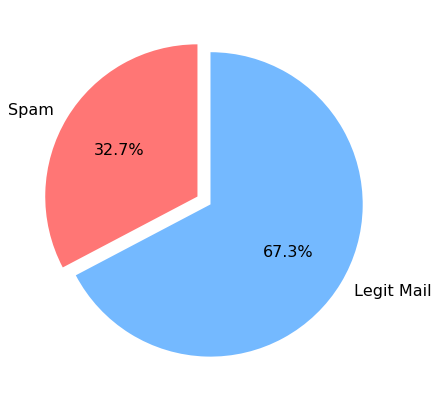

In [33]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

cust_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels = category_names, textprops={'fontsize': 16}, startangle=90,
       autopct='%1.1f%%', colors=cust_colors, explode = [0, 0.1])
plt.show()

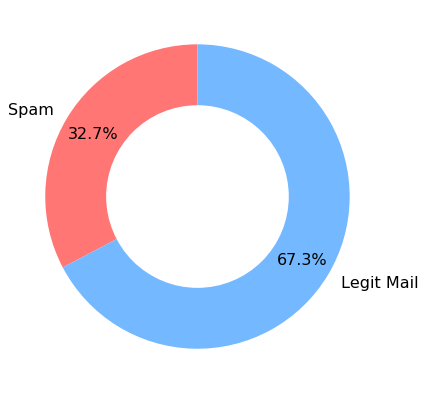

In [34]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

cust_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels = category_names, textprops={'fontsize': 16}, startangle=90,
       autopct='%1.1f%%', colors=cust_colors, pctdistance=0.8)

centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

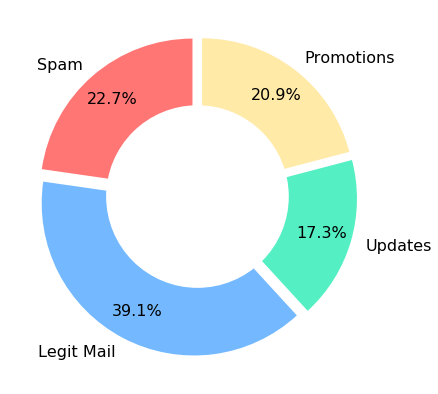

In [35]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 23 ]

cust_colors = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']

offset=[0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels = category_names, textprops={'fontsize': 16}, startangle=90,
       autopct='%1.1f%%', colors=cust_colors, pctdistance=0.8, explode = offset)

centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

## Text Pre-Processing

In [36]:
msg = 'All work and no play make Jack a dull boy.'
msg.lower()

'all work and no play make jack a dull boy.'

### Download NLTK Resources (Tokenizer & Stopwords)

In [37]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Probook\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Probook\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [108]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Probook\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\Probook\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\shakespeare.zip.


True

## Tokenizing

In [39]:
msg = 'All work and no play make Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'make', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words

In [40]:
stop_words = set(stopwords.words('english'))

In [41]:
type(stop_words)

set

In [42]:
print('Found it!') if 'all' in stop_words else print('Nope. Not in here')

Found it!


In [43]:
msg = 'All work and no play make Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []

for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.']


## Words stemming

In [44]:
msg = 'All work and no play make Jack a dull boy. To be or not to be. \
       Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())


#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []

for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Remooving punctuation

In [45]:
msg = 'All work and no play make Jack a dull boy. To be or not to be. \
       Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())


#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []

for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        if stemmed_word.isalpha() : filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags

In [46]:
soup = BeautifulSoup(data.at[0, 'MESSAGE'], 'html.parser')
print(soup.prettify())


<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv="3DContent-T=" ype=""/>
  <meta 5.00.2314.1000"="" content='3D"MSHTML' name="3DGENERATOR"/>
 </head>
 <body>
  <!-- Inserted by Calypso -->
  <table black;="" border="3D0" cellpadding="3D0" cellspacing="3D2" display:="" id="3D_CalyPrintHeader_" none"="" r="ules=3Dnone" style='3D"COLOR:' width='3D"100%"'>
   <tbody>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
   </tbody>
  </table>
 </body>
</html>
<tr>
 <td colspan="3D3">
  <hr color="3Dblack" noshade="" size="3D1"/>
 </td>
</tr>
<!-- End Calypso -->
<!-- Inserted by Calypso=

 -->
<font color="3D#000000" face="3DVERDANA,ARIAL,HELVETICA" size="3D-2">
 <br/>
</font>
&lt;=

/TR&gt;
<!-- End Calypso -->
<font bold"="" color="3D#ff0000" face='3D"Copperplate' gothic="" ptsize='3D"10"' size="3D5">
 <center>
  Save up to 70% on Life Insurance.
 </ce

In [47]:
soup.get_text()

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n\n/TR>\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?\n\n\nLife Quote Savings\n\n\n\n\n\n\n\n\n\n\n\nEnsurin=\n\ng your \n\n      family's financial security is very important. Life Quote Savings ma=\n\nkes \n\n      buying life insurance simple and affordable. We Provide FREE Access =\n\nto The \n\n      Very Best Companies and The Lowest Rates.\n\n\n\n\n\nLife Quote Savings is FAST, EAS=\n\nY and \n\n            SAVES you money! Let us help you get started with the best val=\n\nues in \n\n            the country on new coverage. You can SAVE hundreds or even tho=\n\nusands \n\n            of dollars by requesting a FREE quote from Lifequote Savings. =\n\nOur \n\n            service will take you less than 5 minutes to complete. Shop an=\n\nd \n\n            compare. SAVE up to 70% on all types of Life insurance! \n\n\n\n\nClick Here For Your=\n\n \n\n            Free Quote!\n\nProtecting your family is the best investment you'll 

## Function for Email Processing

In [48]:
def clean_message(message, stemmer = PorterStemmer(),
                 stop_words = set(stopwords.words('english'))):
    
    words = word_tokenize(message.lower())
    
    filtered_words = []

    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [49]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [153]:
def clean_message_no_html(message, stemmer = PorterStemmer(),
                 stop_words = set(stopwords.words('english'))):
    
    message = BeautifulSoup(message, 'html.parser') 
    message = message.get_text()
    
    words = word_tokenize(message.lower())
    
    filtered_words = []

    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [51]:
clean_message_no_html(data.at[0, 'MESSAGE'])

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email']

# Apply Cleaning and Tokenization to all messages

### Slicing Dataframes and Series & Creating Subsets

In [54]:
data.iat[2,0]

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [58]:
data.iloc[5:11]

MESSAGE  CATEGORY  \
DOC_ID                                                                
5       A POWERHOUSE GIFTING PROGRAM You Don't Want To...         1   
6       Help wanted.  We are a 14 year old fortune 500...         1   
7       <html>\n\n<head>\n\n<title>ReliaQuote - Save U...         1   
8       TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...         1   
9       Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...         1   
10      Cellular Phone Accessories All At Below Wholes...         1   

                                     FILE_NAME  
DOC_ID                                          
5       00006.5ab5620d3d7c6c0db76234556a16f6c1  
6       00007.d8521faf753ff9ee989122f6816f87d7  
7       00008.dfd941deb10f5eed78b1594b131c9266  
8       00009.027bf6e0b0c4ab34db3ce0ea4bf2edab  
9       00010.445affef4c70feec58f9198cfbc22997  
10      00011.61816b9ad167657773a427d890d0468e

In [61]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [67]:
 flat_list = []

# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]


len(flat_list)

321

In [68]:
flat_list

['doctyp',
 'html',
 'public',
 'html',
 'html',
 'head',
 'meta',
 'ype',
 'meta',
 'mshtml',
 'bodi',
 'insert',
 'calypso',
 'tabl',
 'color',
 'black',
 'display',
 'none',
 'tbodi',
 'tr',
 'td',
 'hr',
 'noshad',
 'tr',
 'td',
 'hr',
 'noshad',
 'end',
 'calypso',
 'insert',
 'font',
 'arial',
 'helvetica',
 'br',
 'end',
 'calypso',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'save',
 'life',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'spend',
 'center',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'life',
 'quot',
 'save',
 'center',
 'p',
 'p',
 'br',
 'p',
 'center',
 'tabl',
 'tbodi',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'b',
 'font',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'tr',
 'td',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'font',
 'b',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',

In [70]:
%%time

nested_list = data.MESSAGE.apply(clean_message_no_html)

C:\Users\Probook\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 58.7 s


In [71]:
nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [83]:
nested_list.shape

(5796,)

### Using Logic to Slice Dataframes

In [72]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [73]:
data[data.CATEGORY == 0].shape

(3900, 3)

In [77]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [78]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an Index

In [79]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [80]:
type(nested_list)

pandas.core.series.Series

In [81]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [82]:
nested_list_ham.shape

(3900,)

In [84]:
nested_list_ham.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [85]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [101]:
common_spam_words_list = []
common_ham_words_list = []

common_spam_words_list = [item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(common_spam_words_list).value_counts()

common_ham_words_list = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(common_ham_words_list).value_counts()


In [100]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [102]:
spam_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

# Creating Wordcloud

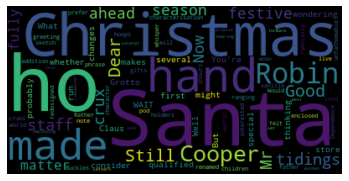

In [107]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [111]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [114]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

In [115]:
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

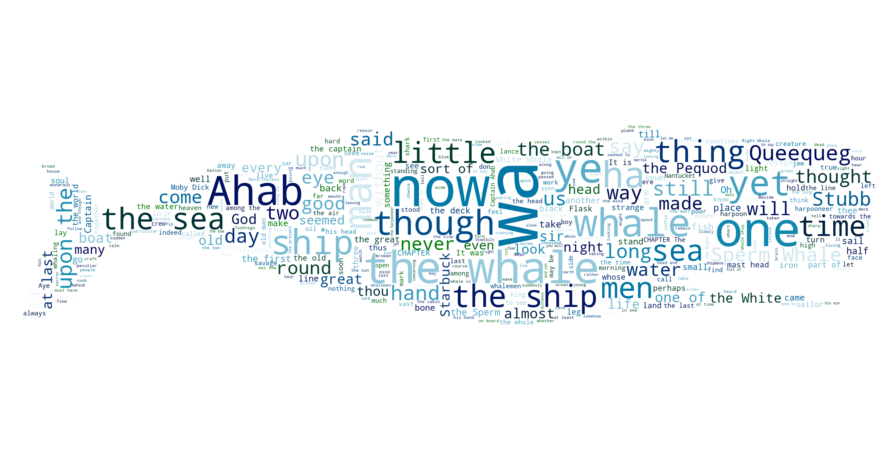

In [134]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=400, colormap='ocean')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

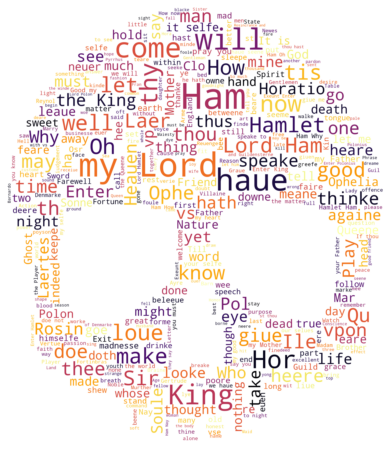

In [137]:
example_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

icon = Image.open(SCULL_FILE)
image_mask = Image.new(mode='RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=400, colormap='inferno')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## WordCloud Spam Messages & Ham Messages

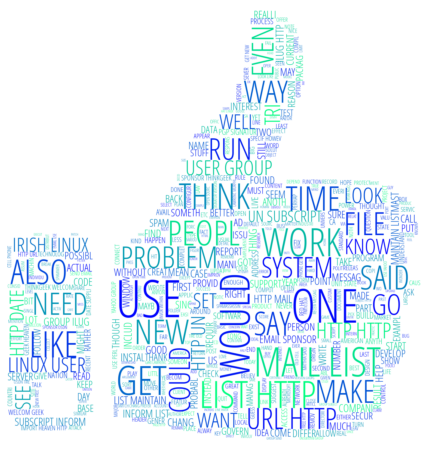

In [151]:
icon = Image.open(THUMB_UP_FILE)
image_mask = Image.new(mode='RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)

ham_str = ' '.join(common_ham_words_list)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=500, colormap='winter', font_path=FONT_FILE_LIGHT)

word_cloud.generate(ham_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

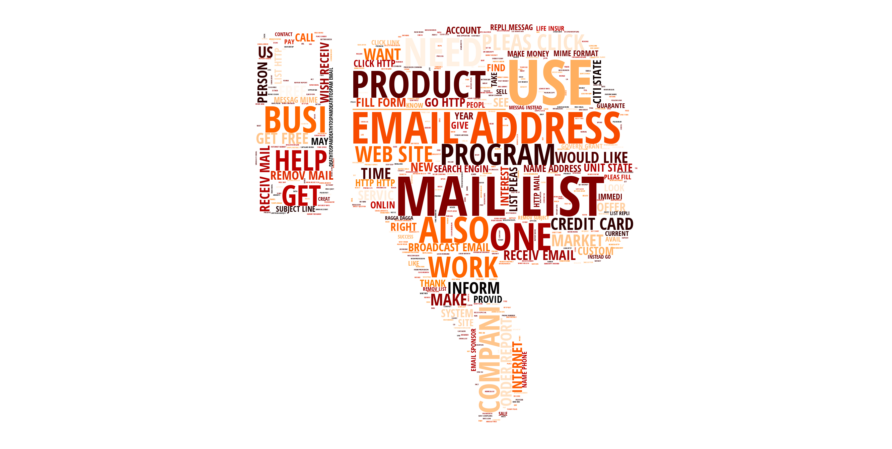

In [149]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)

spam_str = ' '.join(common_spam_words_list)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=500, colormap='gist_heat', font_path=FONT_FILE_BOLD)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocablary & Dictinary

In [154]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_no_html)

C:\Users\Probook\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [155]:
stemmed_nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [156]:
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [205]:
flat_stemmed_list

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email',
 'fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'ch

In [158]:
unique_words = pd.Series(flat_stemmed_list).value_counts()

In [160]:
print('Num if unique', unique_words.shape[0])
unique_words.head()

Num if unique 27305


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [173]:
frequent_words = unique_words.iloc[0:VOCAB_SIZE]

In [174]:
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


## Create Vocablary DataFrame with a WORD_ID

In [178]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab

VOCAB_WORD
WORD_ID           
0             http
1              use
2             list
3            email
4              get
...            ...
2495        burner
2496       subsequ
2497           con
2498     everywher
2499       council

[2500 rows x 1 columns]

## Save the Vocablary as a CSV File

In [180]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header = vocab.VOCAB_WORD.name)

## Exercise: finf if word in the list

In [189]:
def check_w(word):
    for i in range(2500):
        if word == vocab.VOCAB_WORD[i]:
            return True
            break
        return False

In [197]:
check_w('app')

False

In [195]:
vocab.VOCAB_WORD[1]

'use'

In [203]:
'app' in set(vocab.VOCAB_WORD)

True

In [201]:
any(vocab.VOCAB_WORD == 'app')

True

## Exercise: Find email with the most numbers of Words

In [204]:
nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [206]:
stemmed_nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [214]:
list_email_len = []
for sublist in stemmed_nested_list:
    list_email_len.append(len(sublist))


list_email_len = [len(sublist) for sublist in stemmed_nested_list]

max(list_email_len)

7671

In [210]:
num_most = np.argmax(list_email_len)

In [211]:
num_most

5775

In [212]:
data.at[num_most, 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

In [213]:
stemmed_nested_list[num_most]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

# Generate Features & a Sparse Matrix
## Creating a DataFrame with one Word per Column

In [215]:
stemmed_nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [216]:
type(stemmed_nested_list)

pandas.core.series.Series

In [217]:
type(stemmed_nested_list.to_list())

list

In [218]:
stemmed_nested_list.to_list()

[['save',
  'life',
  'insur',
  'spend',
  'life',
  'quot',
  'save',
  'g',
  'famili',
  'financi',
  'secur',
  'import',
  'life',
  'quot',
  'save',
  'ke',
  'buy',
  'life',
  'insur',
  'simpl',
  'afford',
  'provid',
  'free',
  'access',
  'best',
  'compani',
  'lowest',
  'rate',
  'life',
  'quot',
  'save',
  'fast',
  'save',
  'money',
  'let',
  'us',
  'help',
  'get',
  'start',
  'best',
  'ue',
  'countri',
  'new',
  'coverag',
  'save',
  'hundr',
  'even',
  'usand',
  'dollar',
  'request',
  'free',
  'quot',
  'lifequot',
  'save',
  'servic',
  'take',
  'less',
  'minut',
  'complet',
  'shop',
  'compar',
  'save',
  'type',
  'life',
  'insur',
  'click',
  'free',
  'quot',
  'protect',
  'famili',
  'best',
  'invest',
  'r',
  'make',
  'receipt',
  'email',
  'error',
  'wish',
  'remov',
  'list',
  'pleas',
  'click',
  'type',
  'remov',
  'resid',
  'state',
  'prohibit',
  'solicit',
  'ce',
  'pleas',
  'disregard',
  'email'],
 ['fight',
  

In [219]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())

In [220]:
word_columns_df

0        1          2         3           4         5        6     \
0        save     life      insur     spend        life      quot     save   
1       fight     risk     cancer      http        slim  guarante     lose   
2       fight     risk     cancer      http        slim  guarante     lose   
3       adult     club      offer      free  membership   instant   access   
4     thought    might       like      slim    guarante      lose       lb   
...       ...      ...        ...       ...         ...       ...      ...   
5791     http   bizarr    collect      stuf        anim     could    fetch   
5792     care      use        one      also      realli      cute    thing   
5793       sm     skip  montanaro     write      jeremi       put    anoth   
5794     mark  hammond       like     given        zodb     sound  attract   
5795       hi  probabl        use  whatsoev        also   problem   regard   

         7         8        9     ...  7661  7662  7663  7664  7665  7666  \
0           g    famili  financi  ...  None  None  None  None  None  None   
1          lb       day     http  ...  None  None  None  None  None  None   
2          lb       day     http  ...  None  None  None  None  None  None   
3        site      user     name  ...  None  None  None  None  None  None   
4         day      http    fight  ...  None  None  None  None  None  None   
...       ...       ...      ...  ...   ...   ...   ...   ...   ...   ...   
5791     sold   cornwal   museum  ...  None  None  None  None  None  None   
5792  japanes        av     girl  ...  None  None  None  None  None  None   
5793      way  interest     hear  ...  None  None  None  None  None  None   
5794    would    packag    hundr  ...  None  None  None  None  None  None   
5795   nvidia       two   machin  ...  None  None  None  None  None  None   

      7667  7668  7669  7670  
0     None  None  None  None  
1     None  None  None  None  
2     None  None  None  None  
3     None  None  None  None  
4     None  None  None  None  
...    ...   ...   ...   ...  
5791  None  None  None  None  
5792  None  None  None  None  
5793  None  None  None  None  
5794  None  None  None  None  
5795  None  None  None  None  

[5796 rows x 7671 columns]

### Splitting the Data into a Training and Testing Dataset

In [226]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size = 0.3, random_state = 42)

In [227]:
X_train

0        1       2          3            4       5        6     \
4844       ye     inde   agent  directori       verita      cd     unix   
4727  problem     come     tri     instal  harddissssk    like  alreadi   
5022   origin   messag    date        mon          aug    chad  norwood   
3504    inlin     folk   sever      major     internet   outag     morn   
3921      url     http    date       bath     chronicl    None     None   
...       ...      ...     ...        ...          ...     ...      ...   
3772      url     http    date        tue          sep     gmt     wire   
5191   wander  uppsala  sweden       last         week     ran   across   
5226       pm      win   trees      wrote       actual    easi     test   
5390        r   russel  turpin      write            r     hmm     live   
860       see     exit  inform       dear       friend  discov     five   

              7       8         9     ...  7661  7662  7663  7664  7665  7666  \
4844  subdirectori    file      call  ...  None  None  None  None  None  None   
4727         mount    http     yahoo  ...  None  None  None  None  None  None   
5022          sven      cc   subject  ...  None  None  None  None  None  None   
3504        across   major    provid  ...  None  None  None  None  None  None   
3921          None    None      None  ...  None  None  None  None  None  None   
...            ...     ...       ...  ...   ...   ...   ...   ...   ...   ...   
3772        urgent    busi  proposit  ...  None  None  None  None  None  None   
5191       keramik  studio     paula  ...  None  None  None  None  None  None   
5226    experiment  compar    result  ...  None  None  None  None  None  None   
5390          life    hous         r  ...  None  None  None  None  None  None   
860       internet    busi       set  ...  None  None  None  None  None  None   

      7667  7668  7669  7670  
4844  None  None  None  None  
4727  None  None  None  None  
5022  None  None  None  None  
3504  None  None  None  None  
3921  None  None  None  None  
...    ...   ...   ...   ...  
3772  None  None  None  None  
5191  None  None  None  None  
5226  None  None  None  None  
5390  None  None  None  None  
860   None  None  None  None  

[4057 rows x 7671 columns]

In [228]:
X_train.shape

(4057, 7671)

In [231]:
X_train.index.name = X_test.index.name ='DOC_ID'
X_train.head()

0       1      2          3            4      5        6     \
DOC_ID                                                                   
4844         ye    inde  agent  directori       verita     cd     unix   
4727    problem    come    tri     instal  harddissssk   like  alreadi   
5022     origin  messag   date        mon          aug   chad  norwood   
3504      inlin    folk  sever      major     internet  outag     morn   
3921        url    http   date       bath     chronicl   None     None   

                7      8        9     ...  7661  7662  7663  7664  7665  7666  \
DOC_ID                                ...                                       
4844    subdirectori   file     call  ...  None  None  None  None  None  None   
4727           mount   http    yahoo  ...  None  None  None  None  None  None   
5022            sven     cc  subject  ...  None  None  None  None  None  None   
3504          across  major   provid  ...  None  None  None  None  None  None   
3921            None   None     None  ...  None  None  None  None  None  None   

        7667  7668  7669  7670  
DOC_ID                          
4844    None  None  None  None  
4727    None  None  None  None  
5022    None  None  None  None  
3504    None  None  None  None  
3921    None  None  None  None  

[5 rows x 7671 columns]

In [230]:
y_train

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
       ..
3772    0
5191    0
5226    0
5390    0
860     1
Name: CATEGORY, Length: 4057, dtype: int64

### Creating a Sparse Matrix for the Training Data

In [232]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index)

pandas.core.indexes.base.Index

In [233]:
word_index.get_loc('thu')

395

In [237]:
def get_sparse_matrix(df, indexed_word, labels):
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_word)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_word.get_loc(word)
                category = labels[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURANCE': 1, 'WORD_ID': word_id}
                dict_list.append(item)
    
    
    return pd.DataFrame(dict_list)

In [238]:
sparse_train_df = get_sparse_matrix(X_train, word_index, y_train)

In [241]:
sparse_train_df.shape

(430991, 4)

In [242]:
sparse_train_df[-5:]

LABEL  DOC_ID  OCCURANCE  WORD_ID
430986      1     860          1       47
430987      1     860          1     1436
430988      1     860          1       26
430989      1     860          1       19
430990      1     860          1      126

## Combine Occurances with the Pandas groupby() Method

In [274]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURANCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [275]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURANCE
0       0        2      1          1
1       0        3      1          2
2       0        4      1          1
3       0        7      1          3
4       0       11      1          1

In [254]:
vocab.at[7, 'VOCAB_WORD']

'free'

In [253]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [256]:
train_grouped.shape

(258362, 4)

### Save Training Data as .txt File

In [258]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [259]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURANCE'], dtype='object')

## Sparse Matrix fo Test Data

In [266]:
X_test

0        1         2         3          4             5     \
DOC_ID                                                                       
4675        interest    alway    wonder     thing        bad        exampl   
4220             url     http      date     final        gdc         europ   
2484         stephen  william    mailto  swilliam     weaken          food   
2418              el      mon       sep  bitbitch      wrote         eugen   
5110           music   school      joke  american  conductor      european   
...              ...      ...       ...       ...        ...           ...   
5295             thu      jul    joseph   barrera        iii         wrote   
5740    securityfocu    linux  newslett  newslett    sponsor  securityfocu   
5069             thu      jul   matthia      saou      wrote          upon   
1293         tremend     save     toner    inkjet        fax       thermal   
4354        forteana     jayn      ayri     wrote      think        letter   

             6          7         8             9     ...  7661  7662  7663  \
DOC_ID                                                ...                     
4675         goto    languag   support          goto  ...  None  None  None   
4220       review  confernec   session           ect  ...  None  None  None   
2484     transact   argument      note  neighborhood  ...  None  None  None   
2418         mani       homo    friend         lover  ...  None  None  None   
5110    conductor       talk  european     conductor  ...  None  None  None   
...           ...        ...       ...           ...  ...   ...   ...   ...   
5295         chri  arkenberg     wrote         cheer  ...  None  None  None   
5740    deepsight     threat     manag        system  ...  None  None  None   
5069         time    matthia     wrote       subject  ...  None  None  None   
1293    replenish      toner        go        secret  ...  None  None  None   
4354           oh      right      give            go  ...  None  None  None   

        7664  7665  7666  7667  7668  7669  7670  
DOC_ID                                            
4675    None  None  None  None  None  None  None  
4220    None  None  None  None  None  None  None  
2484    None  None  None  None  None  None  None  
2418    None  None  None  None  None  None  None  
5110    None  None  None  None  None  None  None  
...      ...   ...   ...   ...   ...   ...   ...  
5295    None  None  None  None  None  None  None  
5740    None  None  None  None  None  None  None  
5069    None  None  None  None  None  None  None  
1293    None  None  None  None  None  None  None  
4354    None  None  None  None  None  None  None  

[1739 rows x 7671 columns]

In [262]:
y_test

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
       ..
5295    0
5740    0
5069    0
1293    1
4354    0
Name: CATEGORY, Length: 1739, dtype: int64

In [263]:
sparse_test_df = get_sparse_matrix(X_test, word_index, y_test)

In [268]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
test_grouped.head()

OCCURANCE
DOC_ID WORD_ID LABEL           
8      2       1              1
       3       1              4
       4       1              2
       5       1              1
       6       1              2

In [270]:
test_grouped = test_grouped.reset_index()
test_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURANCE
0       8        2      1          1
1       8        3      1          4
2       8        4      1          2
3       8        5      1          1
4       8        6      1          2

In [276]:
test_grouped.shape

(117630, 4)

In [277]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

In [282]:
test_grouped.DOC_ID.value_counts()

2572    1002
1578     925
5208     663
1488     610
5361     589
        ... 
1643       2
1620       2
944        2
71         1
287        1
Name: DOC_ID, Length: 1724, dtype: int64

In [286]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [287]:
len(train_doc_ids)

4015

In [288]:
len(test_doc_ids)

1724

In [293]:
set(X_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [296]:
data.MESSAGE[1544]

'.\n\n\n\nukqdrblkougooeoffnxsmbowei\n\n\n\n\n'

In [297]:
data.loc[1544]

MESSAGE      .\n\n\n\nukqdrblkougooeoffnxsmbowei\n\n\n\n\n
CATEGORY                                                 1
FILE_NAME           01049.621d66148b023203d9010ee5df12ddd1
Name: 1544, dtype: object